In [ ]:
import os
import sys

if os.name == 'nt':
    raise Exception("Windows run is not supported, see README.md. ")

RUN_PLATFORM = os.getenv("RUN_PLATFORM") or "LOCAL"
if 'google.colab' in sys.modules:
    RUN_PLATFORM = "COLAB"

if RUN_PLATFORM == "COLAB":
	print("Notebook is running on Google Colab.\n")
	!curl -L -O https://raw.githubusercontent.com/asztrikx/bme-classification-bird_sounds/refs/heads/master/requirements.txt
	!pip install pytorch-lightning wandb librosa opencv-python pydub dotenv gradio -q
	data_dir = "data"
	os.makedirs(data_dir, exist_ok=True)
	if not os.path.exists("data/train_spectrogram"):
		!gdown 1Kqg7NQ2uAFLa6x1QuP87TXFqx4lR16Gi
		!tar xzfv train_spectrogram.tar.gz -C data/ --checkpoint=.100
		!gdown 1FdPskLKv7u9QNMUcU77uhfd3XhIdD3bS -O data/train_spectrogram.csv
	!curl -L https://raw.githubusercontent.com/asztrikx/bme-classification-bird_sounds/refs/heads/master/.env.template -o .env
	!curl -L https://raw.githubusercontent.com/asztrikx/bme-classification-bird_sounds/refs/heads/master/data/train_metadata_updated.csv -o data/train_metadata_updated.csv
elif RUN_PLATFORM == "LOCAL":
	print("Notebook is running locally.\n")
	# Make sure that when not in docker, packages are installed
	!pip install -r requirements.txt
	data_dir = "data"
elif RUN_PLATFORM == "KAGGLE":
	print("Notebook is running on Kaggle.\n")
	data_dir = ""

# Install ffmpeg for AudioSegment if not already (avoid sudo prompt)
!dpkg-query -W -f='${Status}\n' ffmpeg 2>/dev/null | grep -q "install ok installed" || sudo apt install -y ffmpeg

metadata_path = os.path.join(data_dir, "train_metadata_updated.csv")
audio_dir = os.path.join(data_dir, "train_audio")
spectrogram_dir = os.path.join(data_dir, "train_spectrogram")
os.makedirs(spectrogram_dir, exist_ok=True)
spectrogram_metadata_path = os.path.join(data_dir, "train_spectrogram.csv")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
	# avoid rare bugs when image won't plot
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# loads .env file into runtime env vars
import os.path
if "google.colab" in sys.modules:
	print(
		"You are in Colab so may not see hidden files (starting with '.'). "
		"To see them click on the eye icon in the header part of the Colab "
		"file explorer (where you can browse your files)."
	)
if not os.path.isfile(".env"):
	raise Exception(".env must be created by copying .env.template and filling out the values")
from dotenv import load_dotenv
load_dotenv(override=True)

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
import torchmetrics

# make it not fail in terminal execution
from IPython.display import display
from IPython.display import Audio
import gradio as gr

from types import SimpleNamespace
	# make dict to class
import pathlib
import platform

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from typing import Counter

# Audio process
import librosa
import librosa.display
import cv2
import PIL

# Threading
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

# Wandb
import wandb
wandb.login()
PROJECT_NAME = "bme-classification-bird_sounds"

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: asztrikx (asztrikx-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
d:\File\Study\BME\Msc\Haladó adatelemzés laboratórium\nhf\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Hyperparameter configuration, set random states

In [ ]:
# hyperparameters
test_val_size = 0.2 # size of test and validation together to the whole dataset
test_size = 0.5 # size of test to test and validation together
# number of workers for data loading
if RUN_PLATFORM == "COLAB":
    num_workers = 4
elif RUN_PLATFORM == "LOCAL":
    num_workers = 4

is_score_on = True

# Faster exec. on newer GPUs
torch.set_float32_matmul_precision('medium')

# Fix random early on
random_state = 42 # random state
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Metadata csv

In [ ]:
metadata = pd.read_csv(metadata_path)
metadata = metadata[metadata["delete"] == False].reset_index(drop=True)

## Train test split

In [5]:
# Bugfix, remove datas based on train-test split after segmentation
df = pd.read_csv(spectrogram_metadata_path)
if not 'train_test_val' in metadata.columns and 'train_test_val' in df.columns:
	models = ["cnn", "finetune"]
	for model in models:
		modelPath = f"models/{model}.ckpt"
		if os.path.exists(modelPath):
			os.remove(modelPath)
	recreateSpectrogramTrainTestVal = True
else:
	recreateSpectrogramTrainTestVal = False

This must be done before creating segments, to avoid one audio's segments being in train set and test test also

In [6]:
if not 'train_test_val' in metadata.columns:
	train, test_val = train_test_split(metadata, test_size=test_val_size, random_state=random_state)
	test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)

	metadata.loc[train.index, "train_test_val"] = "train"
	metadata.loc[test.index, "train_test_val"] = "test"
	metadata.loc[val.index, "train_test_val"] = "val"

	metadata.to_csv(metadata_path, index=False)

In [7]:
# Bugfix
if recreateSpectrogramTrainTestVal:
	df = pd.read_csv(spectrogram_metadata_path)
	df.drop(columns=['train_test_val'], inplace=True)
	df = df.merge(metadata[['filename', 'train_test_val']], left_on='audio_path', right_on='filename')
	df.drop(columns=['filename'], inplace=True)
	df.to_csv(spectrogram_metadata_path, index=False)

## Transform data (Cached)

In [ ]:
def process_sound_file(file_path, save=True, save_dir=None, segment_length=3, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
	y, sr = librosa.load(file_path, sr=sr)

	segment_samples = sr * segment_length
	num_segments = int(np.ceil(len(y) / segment_samples))

	spectrogram_paths = []
	spectrograms = []
	for i in range(num_segments):
		start = i * segment_samples
		end = start + segment_samples
		segment = y[start:end]

		#TODO how should padding work
		if len(segment) < segment_samples:
			if num_segments == 1:
				segment = np.pad(segment, (0, segment_samples - len(segment)), mode='wrap')
			else:
				missing_length = segment_samples - len(segment)
				segment = np.concatenate((segment, y[:missing_length]))
		mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
		mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

		mel_spec_resized = cv2.resize(mel_spec_db, (128, 128)) # TODO n_mels?

		if save:
				image_filename = f"{os.path.basename(file_path).replace('.ogg', '')}_seg{i}.png"
				image_path = os.path.join(save_dir, image_filename)
				plt.imsave(image_path, mel_spec_resized, cmap='inferno')

				spectrogram_paths.append(image_path)
		else:
				spectrograms.append(mel_spec_resized)

	return spectrogram_paths, spectrograms

In [ ]:
if not os.path.isfile(spectrogram_metadata_path):
	data = []
	metadata = metadata.iloc[0:2] # TODO avoid ssd murder until figured out

	# Create subdirs outside of loop
	for species in metadata["primary_label"].unique():
		os.makedirs(os.path.join(spectrogram_dir, species), exist_ok=True)

	with tqdm(total=len(metadata)) as pbar:
		with ThreadPoolExecutor() as executor:
			def get_spectrogram(filename):
				audio_path = os.path.join(audio_dir, filename)
				species = filename.split('/')[0]

				out_path = os.path.join(spectrogram_dir, species)
				audio_spectrograms, _ = process_sound_file(audio_path, save_dir=out_path, sr=32000)

				return audio_spectrograms

			futures = {
				executor.submit(get_spectrogram, filename): filename
				for filename in metadata["filename"]
			}
			for future in concurrent.futures.as_completed(futures):
				filename = futures[future]
				audio_spectrograms = future.result()

				# Get other data from metadata: do not do this in Dataset for caching
				row = metadata[metadata["filename"] == filename]
				latitude = row["latitude"].values[0]
				longitude = row["longitude"].values[0]
				author = row["author"].values[0]
				train_test_val = row["train_test_val"].values[0]

				label = species

				for audio_spectrogram in audio_spectrograms:
					audio_spectrogram = os.path.relpath(audio_spectrogram, spectrogram_dir)
					data.append((filename, audio_spectrogram, label, author, latitude, longitude, train_test_val))
				pbar.update(1)

	spectrogram_df = pd.DataFrame(data, columns=["audio_path", "spectrogram_path", "label", "author", "latitude", "longitude", "train_test_val"])
	spectrogram_df.to_csv(spectrogram_metadata_path, index=False)
else:
	spectrogram_df = pd.read_csv(spectrogram_metadata_path)

In [ ]:
# Bugfix: all labels were the last labels
if (spectrogram_df["label"] == "zitcis1").all():
	spectrogram_df["label"] = spectrogram_df["audio_path"].apply(lambda path: path.split('/')[0])
	spectrogram_df.to_csv(spectrogram_metadata_path, index=False)

In [7]:
# Bugfix: Wrong slash type in path
spectrogram_df["spectrogram_path"] = spectrogram_df["spectrogram_path"].apply(lambda path: path.replace('\\', '/'))
spectrogram_df.to_csv(spectrogram_metadata_path, index=False)

## Visualize 1 audio file's spectrograms

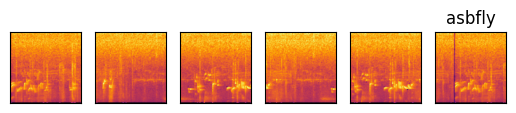

In [52]:
first_spectrograms = spectrogram_df[spectrogram_df["audio_path"] == spectrogram_df.iloc[0]["audio_path"]]
first_spectrograms_paths = first_spectrograms["spectrogram_path"].sort_values(ascending=True)

fig, ax = plt.subplots(1, len(first_spectrograms_paths))
for i, first_spectrograms_path in enumerate(first_spectrograms_paths):
	fullpath = os.path.join(spectrogram_dir, first_spectrograms_path)

	ax[i].imshow(mpimg.imread(fullpath))
	ax[i].set_xticks([])
	ax[i].set_yticks([])

plt.title(spectrogram_df.iloc[0]["label"]);

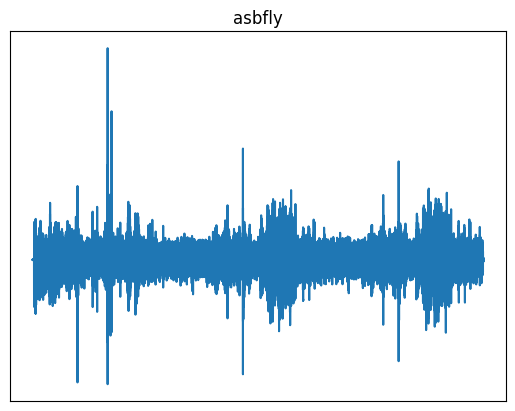

In [29]:
from pydub import AudioSegment

audio = AudioSegment.from_ogg(os.path.join(audio_dir, spectrogram_df.iloc[0]["audio_path"]))
samples = np.array(audio.get_array_of_samples())
if audio.channels == 2:
    samples = samples.reshape((-1, 2))
time_axis = np.linspace(0, len(audio) / 1000, num=len(samples))
plt.xticks([])
plt.yticks([])
plt.title(spectrogram_df.iloc[0]["label"]);
plt.plot(time_axis, samples)

## Custom Dataset

In [ ]:
# Convert string labels to integer label IDs with LabelEncoder
label_encoder = LabelEncoder()
df = pd.read_csv(spectrogram_metadata_path)
df["label_id"] = label_encoder.fit_transform(df["label"])
df.to_csv(spectrogram_metadata_path, index=False)

In [ ]:
class BirdsDataset(Dataset):
	# override
	def __init__(self, csv, train_test_val, transform = None, target_transform = None):
		self.df = pd.read_csv(csv)
		self.df = self.df[self.df["train_test_val"] == train_test_val].reset_index(drop=True)
		self.transform = transform
		self.target_transform = target_transform

	# override
	def __len__(self):
		return len(self.df)

	# override
	def __getitem__(self, index):
		image_path = self.df.iloc[index]["spectrogram_path"]
		if not image_path.startswith("data/train_spectrogram/"):
			image_path = "data/train_spectrogram/" + image_path
		audio = PIL.Image.open(image_path).convert('RGB')
		audio = transforms.functional.to_tensor(audio)

		label = {
			"label": self.df.iloc[index]["label"],
			"label_id": self.df.iloc[index]["label_id"],
			"latitude": self.df.iloc[index]["latitude"],
			"longitude": self.df.iloc[index]["longitude"],
			"author": self.df.iloc[index]["author"],
		}

		if self.transform:
			audio = self.transform(audio).to(torch.float32)
		if self.target_transform:
			label = self.target_transform(label)
		return audio, label

## Data module

In [ ]:
class BirdsDataModule(pl.LightningDataModule):
	def __init__(self, spectrogram_metadata_path, batch_size, base_transform):
		super().__init__()
		self.batch_size = batch_size
		self.base_transform = transforms.Compose([
			base_transform
		])

		self.train_dataset = BirdsDataset(spectrogram_metadata_path, "train", transform = self.base_transform)
		self.val_dataset = BirdsDataset(spectrogram_metadata_path, "val", transform = self.base_transform)
		self.test_dataset = BirdsDataset(spectrogram_metadata_path, "test", transform = self.base_transform)

	# override
	def train_dataloader(self):
		return DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			# Windows: Sanity check hanged, when disabled epoch bar never showed, it just loaded infinitely: https://stackoverflow.com/a/70949425/4404911
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
				# avoid recreating after every fast epoch
		)

	# override
	def val_dataloader(self):
		return DataLoader(
			self.val_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

	# override
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

## Metrics

In [4]:
# TODO: what should go here?

## Baseline

Random

In [ ]:
labels = df["label"].unique()
print(f"Label count: {len(labels)}")
print(f"Chance for random to predict per audio: {1/len(labels) * 100:.2f}%")

tests = df[df["train_test_val"] == "test"]

baseline_random_real = tests["label"]
baseline_random_predicted = np.random.choice(labels, len(tests))

# TODO metrics

Label count: 182
Chance for random to predict per audio: 0.5494505494505495%


In [ ]:
expected_correct = len(tests) * 1 / len(labels)
actual_correct = (baseline_random_real == baseline_random_predicted).sum()
print(f"Expected prediction rate: {expected_correct / len(tests) * 100:.2f}%")
print(f"Got: {actual_correct / len(tests) * 100:.2f}%")

Expected prediction rate: 0.5494505494505494%
Got: 0.46225979000198114%


CNN

In [16]:
batch_size = 1024+128*3

In [ ]:
# https://pytorch-lightning.readthedocs.io/en/0.10.0/lightning_module.html
class CNN(pl.LightningModule):
	def __init__(self, labels_count, learning_rate, weight_decay):
		super().__init__()

		# Log hyperparameters
		self.save_hyperparameters()
		self.learning_rate = learning_rate
		self.weight_decay = weight_decay

		self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=labels_count)

		self.model = torch.nn.Sequential(
			torch.nn.Conv2d(3,64,(4,4),stride=2,padding=1),
			torch.nn.BatchNorm2d(64),
			torch.nn.ReLU(),
			torch.nn.Dropout(0.2),

			torch.nn.Conv2d(64,64,(4,4),stride=2,padding=1),
			torch.nn.BatchNorm2d(64),
			torch.nn.ReLU(),
			torch.nn.Dropout(0.2),

			torch.nn.Flatten(),
			torch.nn.Linear(65536,256),

			torch.nn.BatchNorm1d(256),
			torch.nn.ReLU(),
			torch.nn.Linear(256,labels_count)
		)

	# override
	def forward(self, x):
		return self.model(x)

	# https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.LightningModule.html#lightning.pytorch.core.LightningModule.log
	def common_step(self, batch, batch_idx, train_val_test, prog_bar=False, on_epoch=None):
		pred_labels = self(batch[0])

		loss = F.cross_entropy(pred_labels, batch[1]["label_id"])
		accuracy = self.accuracy(pred_labels, batch[1]["label_id"])

		self.log(f"{train_val_test}_loss", loss, on_epoch=on_epoch, prog_bar=prog_bar)
		self.log(f"{train_val_test}_acc", accuracy, on_epoch=on_epoch, prog_bar=prog_bar)
		return loss

	def training_step(self, batch, batch_idx):
		return self.common_step(batch, batch_idx, "train", on_epoch=True)

	def validation_step(self, batch, batch_idx):
		return self.common_step(batch, batch_idx, "val", prog_bar=True)

	def test_step(self, batch, batch_idx):
		return self.common_step(batch, batch_idx, "test")

	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

def train_cnn(config=None):
	model_name = "cnn"
	if config is None:
		config = {
			"optimizer_name": "adamw",
			"learning_rate": 0.001,
			"weight_decay": 1e-3,
			"epoch": 200,
			"early_stop_patience": 10,
		}

	with wandb.init(config=config, project=PROJECT_NAME):
		config = wandb.config
		wandb_logger = WandbLogger(log_model=True)
		wandb_logger.log_hyperparams(config)
		print(f"\nConfig to be used: {config}\n")

		dm = BirdsDataModule(spectrogram_metadata_path, batch_size, torch.nn.Identity())

		model = CNN(len(labels), config.learning_rate, config.weight_decay)

		trainer = pl.Trainer(
			max_epochs=config.epoch,
			callbacks=[
				pl.callbacks.ModelCheckpoint(
					monitor="val_acc",
					save_top_k=1,
					mode="min",
					dirpath=f'./models/',
					filename=model_name
				),
				pl.callbacks.EarlyStopping(
					monitor="val_acc",
					patience=config.early_stop_patience,
					verbose=False,
					mode="min"
				)
			],
			logger = wandb_logger,
			log_every_n_steps=50,
			accelerator=device,
			devices=1,
			precision="16-mixed",
			#fast_dev_run = True,
		)
		trainer.fit(model, dm)
		trainer.test(dataloaders=dm.test_dataloader())
		return model

In [18]:
def get_cnn(config=None):
	model_name = "cnn"
	if os.path.isfile(f"models/{model_name}.ckpt"):
		model = CNN.load_from_checkpoint(f"models/{model_name}.ckpt", batch_size=batch_size)
			# https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#load-from-checkpoint
	else:
		model = train_cnn(config)

	model.eval()
	return model

wandb.finish()
cnn = get_cnn()

## Model

In [ ]:
val_size = 0.1
test_size = 0.2
epochs = 20
# batch_size = 1024+128*3  # TODO: Why was the batch size this huge? 16-32-64, maximum 500 was the largest I saw so far, ever
barch_size = 32

num_classes = pd.read_csv("data/train_metadata_updated.csv")["primary_label"].nunique()

### Define model

In [ ]:
class BirdSoundsNet(pl.LightningModule):
    def __init__(self, base_model, head_model, num_classes, learning_rate=1e-3, weight_decay=1e-4, freeze_base_model=True):
        super().__init__()
        self.base_model = base_model
        self.freeze_base_model = freeze_base_model

        # Freeze base model
        if self.freeze_base_model:
            for param in self.base_model.parameters():
                param.requires_grad = False
        self.base_model.eval()

        # Define full model
        self.head_model = head_model
        self.model = nn.Sequential(self.base_model, self.head_model)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    # https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.LightningModule.html#lightning.pytorch.core.LightningModule.log
    def common_step(self, batch, batch_idx, train_val_test, prog_bar=False, on_epoch=None):
        pred_labels = self(batch[0])

        loss = F.cross_entropy(pred_labels, batch[1]["label_id"])
        accuracy = self.accuracy(pred_labels, batch[1]["label_id"])

        self.log(f"{train_val_test}_loss", loss, on_epoch=on_epoch, prog_bar=prog_bar)
        self.log(f"{train_val_test}_acc", accuracy, on_epoch=on_epoch, prog_bar=prog_bar)
        return loss

    def training_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx, "train", on_epoch=True)

    def validation_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx, "val", prog_bar=True)

    def test_step(self, batch, batch_idx):
        return self.common_step(batch, batch_idx, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

In [ ]:
from torchvision.models import (
    resnet50,
    ResNet50_Weights,
    mobilenet_v3_large,
    MobileNet_V3_Large_Weights,
    efficientnet_b1,
    EfficientNet_B1_Weights
)

def train_model(config=None):
    model_name = "finetune"
    if config is None:
        config = {
            "learning_rate": 1e-3,
            "weight_decay": 1e-4,
            "base_model": "mobilenet_v3_large",
            "freeze_base_model": True,
            "dropout": 0.2,
            "hidden_layers": 2,
        }

    with wandb.init(config=config, project=PROJECT_NAME):
        config = wandb.config
        wandb_logger = WandbLogger(log_model=True)
        wandb_logger.log_hyperparams(config)
        print(f"\nConfig to be used: {config}\n")

        # Define base model according to config
        base_model_name = config["base_model"]
        if base_model_name == "resnet50":
            base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            preprocess = ResNet50_Weights.IMAGENET1K_V1.transforms()
        elif base_model_name == "mobilenet_v3_large":
            base_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
            preprocess = MobileNet_V3_Large_Weights.IMAGENET1K_V1.transforms()
        elif base_model_name == "efficientnet_b1":
            base_model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
            preprocess = EfficientNet_B1_Weights.IMAGENET1K_V1.transforms()
        else:
            raise ValueError(f"Unknown base model: {base_model_name}")

        # Load spectrogram metadata
        birds_dm = BirdsDataModule(spectrogram_metadata_path, batch_size, preprocess)

        # Define head model according to config
        head_model = nn.Sequential()
        base_model_out_size = base_model.fc.out_features if base_model_name == "resnet50" else base_model.classifier[-1].out_features

        # Add connect layer to head model
        current_hidden_size = 512
        dropout = config["dropout"]
        head_model.add_module(f"layer_connect", nn.Linear(base_model_out_size, current_hidden_size))
        head_model.add_module(f"relu_connect", nn.ReLU())
        head_model.add_module(f"dropout_connect", nn.Dropout(dropout))

        # Add hidden layers to head model
        for layer in range(config["hidden_layers"]):
            head_model.add_module(f"hidden_layer_{layer}", nn.Linear(current_hidden_size, current_hidden_size // 2))
            current_hidden_size = current_hidden_size // 2
            head_model.add_module(f"hidden_relu_{layer}", nn.ReLU())
            head_model.add_module(f"hidden_dropout_{layer}", nn.Dropout(dropout))

        # Add final layer to head model
        head_model.add_module(f"layer_final", nn.Linear(current_hidden_size, num_classes))

        # Instantiate model
        model = BirdSoundsNet(
            base_model=base_model,
            head_model=head_model,
            num_classes=num_classes,
            learning_rate=config["learning_rate"],
            weight_decay=config["weight_decay"],
            freeze_base_model=config["freeze_base_model"],
        )

        # Register checkpointing and early stopping callbacks
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            monitor="val_acc", # TODO: should be 'val_acc' in the future
            save_top_k=1,
            mode="max",
            dirpath='./models/',
            filename=f"{model_name}_{config["hidden_layers"]}_{config["dropout"]}_{config["learning_rate"]}_{config["weight_decay"]}_{config["freeze_base_model"]}_{config["base_model"]}"
        )
        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor="val_acc", # TODO: should be 'val_acc' in the future
            patience=3,
            verbose=False,
            mode="max",
        )

        trainer = pl.Trainer(
            max_epochs=epochs,
            callbacks=[checkpoint_callback, early_stop_callback],
            logger = wandb_logger,
            # Sanity check overruns max memory
            num_sanity_val_steps=0,
            log_every_n_steps=50,
            accelerator=device,
            devices=1,
            precision="16-mixed",
                # 32 biten tárolva, de a lényeges számítások 16 biten
        )

        # Train the model
        trainer.fit(model, datamodule=birds_dm)
        trainer.test(model, datamodule=birds_dm)

        return model

### Train without or without `Wandb` sweeps

In [ ]:
def get_model(config=None):
	model_name = "finetune"
	if os.path.isfile(f"models/{model_name}.ckpt"):
		model = BirdSoundsNet.load_from_checkpoint(f"models/{model_name}.ckpt", batch_size=batch_size)
			# https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#load-from-checkpoint
	else:
		wandb.finish()
		if True:
			model = train_model(config)
		else:
			sweep_config = {
				'method': 'random',  # TODO: should try 'bayesian' or 'grid'
				'metric': {
					'name': 'val_acc',  # TODO: should be 'val_acc' in the future
					'goal': 'maximize'
				},
				'parameters': {
					'hidden_layers': {
						'values': [1, 2, 3]
					},
					'dropout': {
						'values': [0.1, 0.3, 0.5]
					},
					'learning_rate': {
						'values': [1e-3, 1e-4]
					},
					'weight_decay': {
						'values': [0, 1e-4, 1e-5]
					},
					'freeze_base_model': {
						'values': [True]
					},
					'base_model': {
						'values': ['resnet50', 'mobilenet_v3_large', 'efficientnet_b1']
					}
				}
			}
			sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)
			wandb.agent(sweep_id, train_model, count=10)
		wandb.finish()

	model.eval()
	return model

model = get_model()

## Final application (`Gradio`)

In [ ]:
# Parameters
SEGMENT_LENGTH = 3

base_model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
preprocess = EfficientNet_B1_Weights.IMAGENET1K_V1.transforms()

# Instantiate dummy model (TODO: replace with fully trained one)
model = BirdSoundsNet(
    base_model=base_model,
    head_model=nn.Linear(base_model.classifier[-1].out_features, num_classes),
    num_classes=num_classes,
    learning_rate=1e-4,
    weight_decay=1e-4,
    freeze_base_model=True,
)
model = model.to(device)

### Utility functions to help with prediction and visualization

In [ ]:
def label_id_to_label(label_id):
    """Convert label id to label name."""
    if label_id is None:
        return None
    try:
        return label_encoder.inverse_transform([label_id])[0]
    except ValueError:
        return "Unknown"

def get_nth_predicted_class(predicted_classes, n):
    """Return the nth predicted class and its ratio in light of all the input audio segments."""
    if n >= len(predicted_classes):
        return {"class": None, "ratio": None}

    counter_list = Counter(predicted_classes).most_common(3)
    if n >= len(counter_list):
        return {"class": None, "ratio": None}

    predicted_class = counter_list[n][0]
    predicted_class_ratio = counter_list[n][1] / len(predicted_classes)
    return {"class": predicted_class, "ratio": predicted_class_ratio}

@torch.inference_mode()
def predict_class_from_multiple_spectrograms(spectrograms, model, preprocess):
    """Predict class from multiple spectrograms (e.g. from multiple audio segments from a single input audio)."""
    model.eval()
    predicted_classes = []

    # Iterate through spectrograms
    for spectrogram in spectrograms:
        # Preprocess spectrogram
        spectrogram = PIL.Image.fromarray(np.uint8(spectrogram)).convert('RGB')
        spectrogram = transforms.functional.to_tensor(spectrogram)
        spectrogram = preprocess(spectrogram).to(torch.float32).unsqueeze(0).to(device)

        # Make prediction
        prediction = model(spectrogram)
        predicted_class = torch.argmax(prediction, dim=1).item()
        predicted_classes.append(predicted_class)

    return predicted_classes

@torch.inference_mode()
def predict_class(audio_path):
    """Predict class from a single input audio file with the 3 most common predicted classes."""
    # Preprocess audio file and produce spectrograms with specified parameters
    _, spectrograms = process_sound_file(audio_path, save=False)

    # Run inference with the model or mock it out
    if model is not None:
        predicted_classes = predict_class_from_multiple_spectrograms(spectrograms, model, preprocess)
        prediction_1 = get_nth_predicted_class(predicted_classes, 0)
        prediction_2 = get_nth_predicted_class(predicted_classes, 1)
        prediction_3 = get_nth_predicted_class(predicted_classes, 2)
    else:
        prediction_1 = {"class": "mocked_class", "ratio": None}
        prediction_2 = {"class": "mocked_class", "ratio": None}
        prediction_3 = {"class": "mocked_class", "ratio": None}
        predicted_classes = ["mocked_class"] * len(spectrograms)

    # Normalize for Gradio (necessary, only accepts [-1, 1] images)
    normalized_spectrograms = [
        (mel_spec_resized - np.min(mel_spec_resized)) / (np.max(mel_spec_resized) - np.min(mel_spec_resized))
        for mel_spec_resized in spectrograms
    ]

    spectrograms_with_pred_labels = [
        (normalized_spectrograms[i], f"Segment: {i}, Class: '{label_id_to_label(predicted_classes[i])} ({predicted_classes[i]})'")
         for i in range(len(normalized_spectrograms))
    ]

    return (
        f"{label_id_to_label(prediction_1['class'])} ({prediction_1['class']})", prediction_1["ratio"],
        f"{label_id_to_label(prediction_2['class'])} ({prediction_2['class']})", prediction_2["ratio"],
        f"{label_id_to_label(prediction_3['class'])} ({prediction_3['class']})", prediction_3["ratio"],
        spectrograms_with_pred_labels
    )

### Launch the app

In [ ]:
def create_app(process):
    """Create Gradio bird sound classification app."""
    with gr.Blocks() as app:
        title = gr.HTML("<h1>chirp.ai 🐦</h1>")  # TODO: revise name, this is a prototype
        subtitle = gr.HTML("<h3><i>Bird Sound Classification with a Deep Neural Network</i></h3>")

        with gr.Row():
            with gr.Column(scale=2, min_width=300):
                audio_file = gr.Audio(type="filepath", label="Audio to classify")

                with gr.Accordion("Spectrogram view", open=False):
                    spectrogram_images = gr.Gallery(
                        label=f"Mel spectrograms of the audio ({SEGMENT_LENGTH} second segments)",
                        columns=5,
                        object_fit="scale-down"
                    )

            with gr.Column(scale=1, min_width=300):
                with gr.Group():
                    with gr.Column():
                        with gr.Row():
                            result = gr.Textbox(label="1st predicted class", interactive=False)
                            result_ratio = gr.Textbox(label="Ratio of all segments", interactive=False)
                        with gr.Row():
                            result_2 = gr.Textbox(label="2nd predicted class", interactive=False)
                            result_ratio_2 = gr.Textbox(label="Ratio of all segments", interactive=False)
                        with gr.Row():
                            result_3 = gr.Textbox(label="3rd predicted class", interactive=False)
                            result_ratio_3 = gr.Textbox(label="Ratio of all segments", interactive=False)

                submit_button = gr.Button("Predict")
                submit_button.click(
                    process,
                    inputs=audio_file,
                    outputs=[
                        result, result_ratio, result_2, result_ratio_2,
                        result_3, result_ratio_3, spectrogram_images
                    ]
                )

    return app

app = create_app(predict_class)
app.queue().launch(debug=True)